In [40]:
import numpy as np 
import pandas as pd

import random
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score

import lightgbm as lgb

from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
rng = np.random.RandomState(123)

## Dataset

In [7]:
filepath = "/home/28ed2e24-6dc0-4639-9c20-93842c733782/puboost/notebooks/input/marketing_campaign.csv"
df = pd.read_csv(filepath , sep = '\t')

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [8]:
df = df.set_index('Dt_Customer')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2240 entries, 04-09-2012 to 15-10-2012
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 no

In [10]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [11]:
df['Response'].value_counts()

0    1906
1     334
Name: Response, dtype: int64

In [12]:
# Data process
df['Age'] = df.apply(lambda row: 2023- int(row.Year_Birth), axis=1)

df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], prefix=['Education', 'Marital'])

df = df.dropna()

In [13]:
X = df.drop(columns=['Response'])
y = df['Response']

# Tasa de contaminación (convertir la mitad de los 1s en 0s)
contamination = 0.5

# Obtener los índices de los 1s en la Serie
indices_ones = y[y == 1].index

# Determinar cuántos 1s convertir a 0s
num_to_convert = int(len(indices_ones) * contamination)

# Usar una semilla aleatoria para garantizar reproducibilidad
random.seed(42)

# Seleccionar aleatoriamente los índices de 1s a convertir
idx_hidden = random.sample(indices_ones.tolist(), num_to_convert)

# Modificar el DataFrame y convirtiendo los 1s seleccionados a 0s
y_true = y.copy()
y = y.copy()
y.loc[idx_hidden] = 0

y_true.loc[idx_hidden] = 1
y_true = y_true[y == 0]

## Modelos base

In [15]:
### Classification Model and predictions

# classifier
clf = 'tree'
# classifier param
kwargs_clf = {'min_samples_leaf': 0.1}

# train
if clf=='rf':
    mod = RandomForestClassifier(random_state=rng, **kwargs_clf)
elif clf=='logistic':
    mod = LogisticRegression(random_state=rng, **kwargs_clf)
elif clf=='tree':
    mod = DecisionTreeClassifier(random_state=rng, **kwargs_clf)

# fit    
mod.fit(X, y)

# predict
predh = mod.predict_proba(X.loc[y==0,:])[:, mod.classes_ == 1].ravel()

# average precision
average_precision_score(y_true, predh)

0.34102636833572075

In [16]:
def smartbagged_clf(X_seed, X_poblacion, random_state, T=50, clf='logistic', 
                    l1=1, l2=1, e1=1, e2=1, **kwargs_clf):
    """
    Returns avg of oob predictions of classifier para la poblacion
    Param:
        - T number of baggint iteractions 
        - clf: base estimator (one of rg, logistic)
    """
    # K: size of boostrap sample (= size of seed)
    K = X_seed.shape[0]
    # U: size of poblation
    U = X_poblacion.shape[0]
    # se entrena con una muestra balanceada
    # vector target: primero seed - luego poblacion
    y_poblacion = np.zeros(U)
#     y_train = np.concatenate([np.ones(K), np.zeros(K)])
    # initialize numerador de predicciones
    pred = np.zeros(U)
    # initialize denominador de predicciones
    n = np.zeros(U)
    # iniialize weight vectors
    w_poblacion = np.ones(U)
    w_seed = np.ones(K)

    # bagging
    for t in range(T):
        # get sample
        idx_train = np.random.choice(U, K, replace=True)
        X_train = np.concatenate([X_seed, X_poblacion.iloc[idx_train,:]])
        # y_train vector
        y_train = np.concatenate([np.ones(K), y_poblacion[idx_train]])
        # weights
        # print(w_poblacion[idx_train], "/n")
        weights = np.concatenate([w_seed, w_poblacion[idx_train]])      
        # train
        if clf=='rf':
            clf = RandomForestClassifier(**kwargs_clf)
        if clf=='logistic':
            clf = LogisticRegression(**kwargs_clf)
        if clf=='tree':
            clf = DecisionTreeClassifier(**kwargs_clf)
        if clf=='knn':
            clf = KNeighborsClassifier(**kwargs_clf)
        clf.fit(X_train, y_train, sample_weight = weights)
        # predict OOB
        idx_oob = np.full(U, True)
        idx_oob[idx_train] = False
        _pred = clf.predict_proba(X_poblacion.iloc[idx_oob,:])[:,clf.classes_ == 1].ravel()
        pred[idx_oob] += _pred
        n[idx_oob] += 1
        # update weight vector
        if t > (T*l1):
            _wupdate = np.zeros(U)
            _wupdate[idx_oob] = _pred
            w_poblacion += (-_wupdate/T*l2) 
        if t > (T*e1):
            y_poblacion[(pred/n)>e2] = 1
    scores = pred / n
    return scores

0.4685376120164927


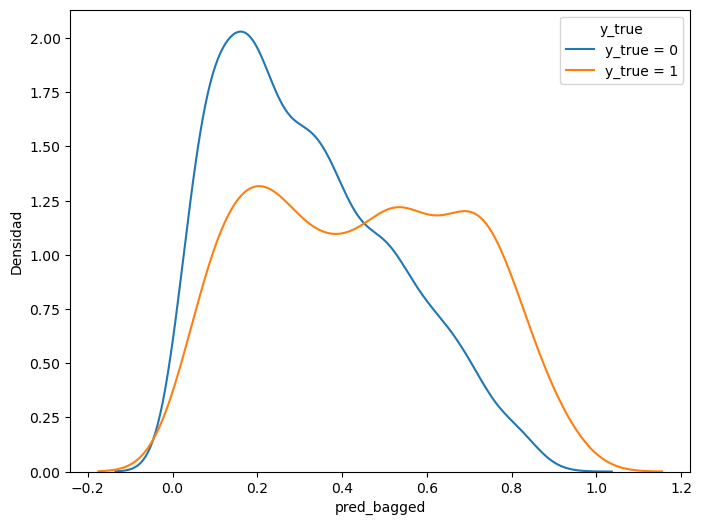

In [17]:
pclf='tree'
pkwargs_clf = {'min_samples_leaf': 5}

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# predict bagged
pred_bagged = smartbagged_clf(pd.DataFrame(X.loc[y==1, :]), pd.DataFrame(X.loc[y==0, :]),
                         random_state = 42, T=100, clf=pclf, l1=1, l2=1, **pkwargs_clf)

# average precision
print(average_precision_score(y_true, pred_bagged))

# Crea el gráfico de densidad
plt.figure(figsize=(8, 6))
sns.kdeplot(data=pred_bagged[y_true==0], label='y_true = 0')
sns.kdeplot(data=pred_bagged[y_true==1], label='y_true = 1')

# Agrega etiquetas y leyenda
plt.xlabel('pred_bagged')
plt.ylabel('Densidad')
plt.legend(title='y_true')

# Muestra el gráfico
plt.show()

## Hiperparamerizacion

En esta seccion vamos a replicar lo que hicimos en la anterior, pero en este caso sumando un paso de busqueda de hiperparametros optimos para los dos metodos de aprendizaje

#### LightGBM 

In [84]:
# Define the hyperparameter search space.
param_space = {
    'num_leaves': Integer(2, 100),
    'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'feature_fraction': Real(0.1, 1.0),
    # Add more hyperparameters to search over
}

# Create a loop to run 20 random parameter selections and fit LightGBM models.
results_clf = []

for iteration in range(20):
    # Randomly select hyperparameters from the search space.
    random_params = {param: space.rvs(1)[0] for param, space in param_space.items()}

    # Create and train the LightGBM model with the random hyperparameters.
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        boosting_type='gbdt',
        **random_params
    )
    model.fit(X, y)

    # Evaluate the model on the test data and store the ROC AUC score.
    y_pred = model.predict_proba(X.loc[y==0,:])[:, model.classes_ == 1].ravel()
    av_pre = average_precision_score(y_true, y_pred)

    # Store the results.
    results_clf.append({
        'iteration': iteration + 1,
        'params': random_params,
        'av_pre': av_pre
    })

    print(f"Iteration {iteration + 1} - AV PRE: {av_pre:.2f}")

# Find the best performing model.
best_result = max(results_clf, key=lambda x: x['av_pre'])
print(best_result)

[LightGBM] [Warning] feature_fraction is set=0.54573770475547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54573770475547
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.54573770475547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.54573770475547
[LightGBM] [Info] Number of positive: 118, number of negative: 2098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1899
[LightGBM] [Info] Number of data points in the train set: 2216, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053249 -> initscore=-2.878055
[LightGBM] [Info] Start training from score -2.878055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [104]:
# Define the hyperparameter search space.
pclf='tree'
pkwargs_clf = {'min_samples_leaf': 5}

# Create a loop to run 20 random parameter selections and fit LightGBM models.
results_sbg = []

for iteration in range(20):
    # Randomly select hyperparameters from the search space.

    l1, l2, e1, e2 = [random.random() for _ in range(4)]
    print(l1, l2, e1, e2)
    
    # Create and train the LightGBM model with the random hyperparameters.
    pred_bagged = smartbagged_clf(pd.DataFrame(X.loc[y==1, :]), pd.DataFrame(X.loc[y==0, :]),
                                  random_state = 42, T=100, clf=pclf,
                                  l1=l1, l2=l2,
                                  e1=e1, e2=e2, **pkwargs_clf)

    
    # Evaluate the model on the test data and store the ROC AUC score.
    av_pre = average_precision_score(y_true, pred_bagged)

    # Store the results.
    results_sbg.append({
        'iteration': iteration + 1,
        'av_pre': av_pre
    })

    print(f"Iteration {iteration + 1} - AV PRE: {av_pre:.2f}")

# Find the best performing model.
best_result_sbg = max(results_sbg, key=lambda x: x['av_pre'])

print(best_result_sbg)

0.6153774441639687 0.2482702803811866 0.8653075017207177 0.15969966213016096
Iteration 1 - AV PRE: 0.46
0.32743582080119493 0.5776870378935964 0.31271492086227304 0.7631213751386285
Iteration 2 - AV PRE: 0.46
0.4982655420599088 0.5147248392314845 0.49875970839765416 0.3085404820544293
Iteration 3 - AV PRE: 0.44
0.023176298216351032 0.9452328040692373 0.5054444630237716 0.9666866305524754
Iteration 4 - AV PRE: 0.46
0.2151444225262411 0.35289508885635534 0.05054040462789189 0.4948942035251763
Iteration 5 - AV PRE: 0.42
0.8823394763682011 0.6542600368896171 0.4705868533681957 0.536690749288927
Iteration 6 - AV PRE: 0.45
0.8471723653934679 0.4309277693475405 0.8824557309185929 0.7275080633593919
Iteration 7 - AV PRE: 0.46
0.7638567641619896 0.365937352517563 0.4005816210147566 0.5702816438810293
Iteration 8 - AV PRE: 0.46
0.19465530188771907 0.5532229266211517 0.07353174974284182 0.5042555291232047
Iteration 9 - AV PRE: 0.40
0.7644041147072396 0.279720677623982 0.9890907006207226 0.6803986